## Setup

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import numpy as np
import pandas as pd
import random
import tensorflow as tf
import isuelogit as isl
import glob

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/gisuelogit


In [48]:
# Internal modules
from src.gisuelogit.visualizations import plot_predictive_performance, plot_convergence_estimates
from src.gisuelogit.etl import data_curation, add_period_id

## Read spatiotemporal data

In [50]:
folderpath = isl.config.dirs['read_network_data'] + 'links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df[df['date'].dt.dayofweek.between(0, 3)]
# df = df[df['date'].dt.year == 2019]

df['period'] = df['date'].astype(str) + '-' + df['hour'].astype(str)
df['period'] = df.period.map(hash)

In [51]:
# Add period id for timevarying estimation

period_feature = 'hour'

df['period'] = df['date'].astype(str) + '-' + df[period_feature].astype(str)
# df['period'] = df.period.map(hash)

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


## Data curation

In [52]:
df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

df = data_curation(df)

KeyError: 'tt_sd_adj'

In [53]:
df[['speed_ref_avg','speed_hist_avg', 'tt_ff', 'tt_avg']].describe()

,speed_ref_avg,speed_hist_avg,tt_ff,tt_avg
count,1.013460e+06,1.009583e+06,1.013460e+06,887813.000000
mean,1.924470e+01,1.767589e+01,3.397371e-03,0.003604
std,1.982261e+01,1.909664e+01,4.350074e-03,0.004321
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,2.112700e+01,1.755400e+01,2.495627e-03,0.002735
75%,2.796200e+01,2.547600e+01,4.653995e-03,0.005150
max,6.772900e+01,7.891400e+01,7.034335e-02,0.063791


## Data processing

In [54]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year

In [55]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'speed_avg']].describe()

,counts,tt_ff,tt_avg,tf_inrix,speed_avg
count,31624.000000,542925.000000,468303.000000,542925.000000,542925.000000
mean,1761.140959,0.003415,0.003639,0.200169,17.946237
std,770.228931,0.004370,0.004399,0.228208,20.262676
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1249.000000,0.000000,0.000000,0.000000,0.000000
50%,1686.000000,0.002508,0.002753,0.152000,16.000000
75%,2162.450000,0.004702,0.005230,0.280000,27.340000
max,4807.000000,0.070343,0.063791,2.302000,75.652000


In [56]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'speed_avg']].describe()

,counts,tt_ff,tt_avg,tf_inrix,speed_avg
count,27472.000000,470535.000000,419510.000000,470535.000000,470535.000000
mean,1605.127777,0.003377,0.003564,0.198494,19.650807
std,743.713869,0.004326,0.004232,0.226003,20.229134
min,6.000000,0.000000,0.000000,0.000000,0.000000
25%,1108.450000,0.000000,0.000000,0.000000,0.000000
50%,1528.900000,0.002491,0.002717,0.150000,20.505000
75%,1978.000000,0.004578,0.005064,0.273000,28.117000
max,4766.000000,0.070343,0.054574,2.113000,73.943000


In [57]:
print(1-1793.271103/1865.514775, 1-17.469430/18.895705)


0.03872586428590474 0.07548143877140334


## EDA

### Link attributes

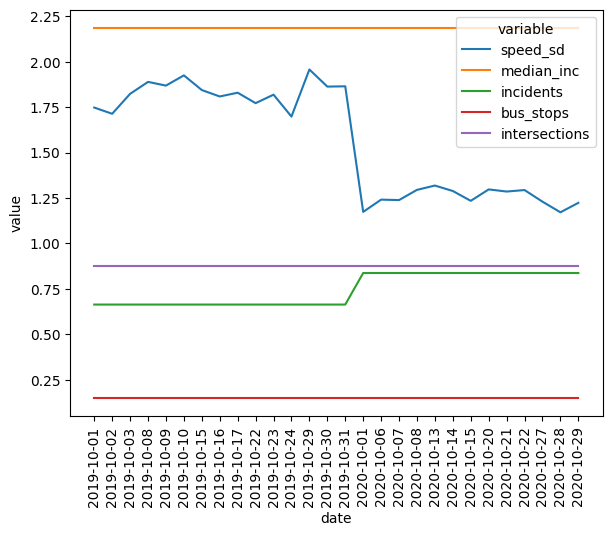

In [58]:
features_Z = ['speed_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

sns.lineplot(x= 'date', y = 'value', hue = 'variable', data =pd.melt(eda_df.groupby('date')[features_Z].mean().reset_index(),id_vars= ['date']))
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

## Analyze single file of inrix data

In [59]:
inrix_df = pd.read_csv(f"{os.getcwd()}/input/private/inrix/2020-10-01.csv")
inrix_df['ts'] = pd.to_datetime(inrix_df['UTC Date Time'])
inrix_df['hour'] = inrix_df.ts.dt.hour
inrix_df['speed'] = inrix_df['Speed(km/hour)']*0.62137119223

In [60]:
# Select data from same time range
inrix_df = inrix_df[inrix_df.hour.isin(range(4,23))]

In [61]:
inrix_df.head()

,Date Time,Segment ID,UTC Date Time,Speed(km/hour),Hist Av Speed(km/hour),Ref Speed(km/hour),Travel Time(Minutes),CValue,Pct Score30,Pct Score20,Pct Score10,Road Closure,Corridor/Region Name,ts,hour,speed
4,2020-10-01,1626763236,2020-10-01 04:00:00,52.0,48.0,42.0,0.13,90.0,100.0,0.0,0.0,F,Fresno_CA,2020-10-01 04:00:00,4,32.311302
5,2020-10-01,1626763236,2020-10-01 04:15:00,51.0,47.0,42.0,0.15,90.0,53.0,47.0,0.0,F,Fresno_CA,2020-10-01 04:15:00,4,31.689931
6,2020-10-01,1626763236,2020-10-01 04:30:00,47.0,47.0,42.0,0.15,NaN,0.0,100.0,0.0,F,Fresno_CA,2020-10-01 04:30:00,4,29.204446
7,2020-10-01,1626763236,2020-10-01 04:45:00,45.0,45.0,42.0,0.17,NaN,0.0,100.0,0.0,F,Fresno_CA,2020-10-01 04:45:00,4,27.961704
8,2020-10-01,1626763236,2020-10-01 05:00:00,48.0,48.0,42.0,0.15,NaN,0.0,100.0,0.0,F,Fresno_CA,2020-10-01 05:00:00,5,29.825817


In [62]:
inrix_df.describe()

,Segment ID,Speed(km/hour),Hist Av Speed(km/hour),Ref Speed(km/hour),Travel Time(Minutes),CValue,Pct Score30,Pct Score20,Pct Score10,hour,speed
count,1.020604e+06,1.020300e+06,940434.000000,1.020604e+06,1.020300e+06,705930.000000,1.020300e+06,1.020300e+06,1.020300e+06,1.020604e+06,1.020300e+06
mean,7.942554e+08,5.513983e+01,54.284333,5.593239e+01,4.545113e-01,95.063257,6.403537e+01,2.810540e+01,7.859205e+00,1.300000e+01,3.426230e+01
std,6.271538e+08,2.324176e+01,23.336311,2.250260e+01,4.023858e-01,5.040026,4.606894e+01,4.291665e+01,2.655070e+01,5.477228e+00,1.444176e+01
min,1.684284e+08,6.000000e+00,6.000000,1.000000e+01,0.000000e+00,50.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,3.728227e+00
25%,3.999621e+08,3.900000e+01,37.000000,4.000000e+01,1.300000e-01,90.000000,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00,2.423348e+01
50%,4.416791e+08,4.900000e+01,48.000000,5.000000e+01,3.500000e-01,96.670000,1.000000e+02,0.000000e+00,0.000000e+00,1.300000e+01,3.044719e+01
75%,1.626652e+09,7.100000e+01,71.000000,7.100000e+01,6.700000e-01,100.000000,1.000000e+02,8.000000e+01,0.000000e+00,1.800000e+01,4.411735e+01
max,1.626775e+09,1.220000e+02,122.000000,1.140000e+02,8.170000e+00,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,2.200000e+01,7.580729e+01


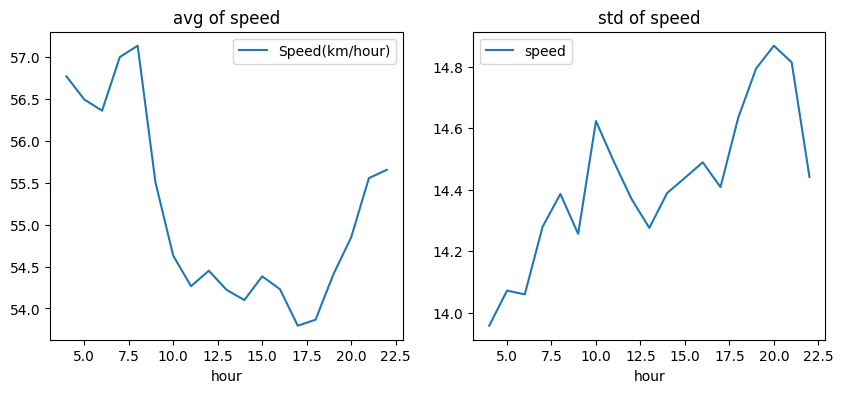

In [63]:
fig, axs = plt.subplots(1,2, figsize = (10,4))

sns.lineplot(data = inrix_df.groupby('hour')[['Speed(km/hour)']].mean(),
             ax = axs[0])
axs[0].set_title('avg of speed')

sns.lineplot(data = inrix_df.groupby('hour')[['speed']].std(),
             ax = axs[1])
axs[1].set_title('std of speed');

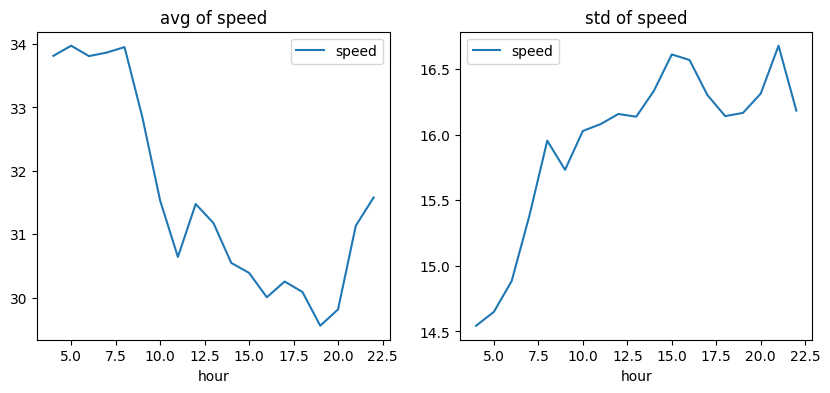

In [64]:
# Filter only data from inrix segments that were matched with the network links

fig, axs = plt.subplots(1,2, figsize = (10,4))

sns.lineplot(data = inrix_df[inrix_df['Segment ID'].isin(list(df.inrix_id.dropna().unique()))].groupby('hour')[['speed']].mean(),
             ax = axs[0])
axs[0].set_title('avg of speed')

sns.lineplot(data = inrix_df[inrix_df['Segment ID'].isin(list(df.inrix_id.dropna().unique()))].groupby('hour')[['speed']].std(),
             ax = axs[1])
axs[1].set_title('std of speed');

## Stats by date

In [65]:
# To check that there is a balanced amount of observations per date
obs_date = df.groupby('date')['hour'].count()

In [66]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts']].mean().assign(total_obs = obs_date)

,speed_sd,speed_avg,counts,total_obs
date,,,,
2019-10-01,1.731787,17.175187,1770.335035,36195
2019-10-02,1.760109,17.169768,1746.651824,36195
2019-10-03,1.754288,17.092304,1785.115209,36195
2019-10-08,1.847060,18.165569,1747.732955,36195
2019-10-09,1.917923,18.137042,1756.834846,36195
2019-10-10,1.830232,18.107925,1793.512340,36195
2019-10-15,1.831527,18.114384,1750.339155,36195
2019-10-16,1.823680,18.162625,1760.170975,36195
2019-10-17,1.832219,18.080860,1775.411385,36195


### Cross sectional

In [67]:
# eda_df = df[df.year == 2019].copy()
eda_df = df.copy()
eda_df['date'] = eda_df['date'].astype(str)

# Transform to monthly income
eda_df['median_inc'] = eda_df['median_inc']/12

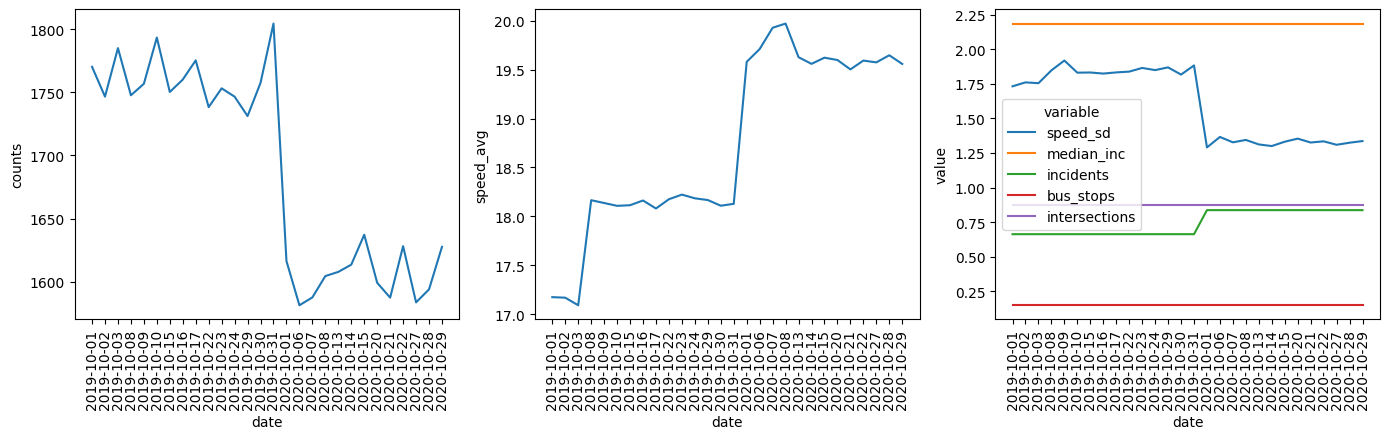

In [68]:
fig, axs = plt.subplots(1,3, figsize = (14,4.5))

sns.lineplot(x= 'date', y = 'counts', data =eda_df.groupby('date')[['counts']].mean().reset_index(),
             ax = axs[0])

sns.lineplot(x= 'date', y = 'speed_avg', data =eda_df.groupby('date')[['speed_avg']].mean().reset_index(),
             ax = axs[1])

sns.lineplot(x= 'date', y = 'value', hue = 'variable', data =pd.melt(eda_df.groupby('date')[features_Z].mean().reset_index(),id_vars= ['date']),
             ax = axs[2])

#list(map(lambda x: x.set_xticklabels(x.get_xticks(), rotation=90), axs));
fig.autofmt_xdate(rotation = 90, ha = 'center')
fig.tight_layout()

### By hour of day

In [69]:
link_keys = eda_df[(eda_df.counts>0) & (eda_df.speed_avg>0)].link_key.unique()
link_keys = link_keys[0:10]

<AxesSubplot: xlabel='hour', ylabel='speed_avg'>

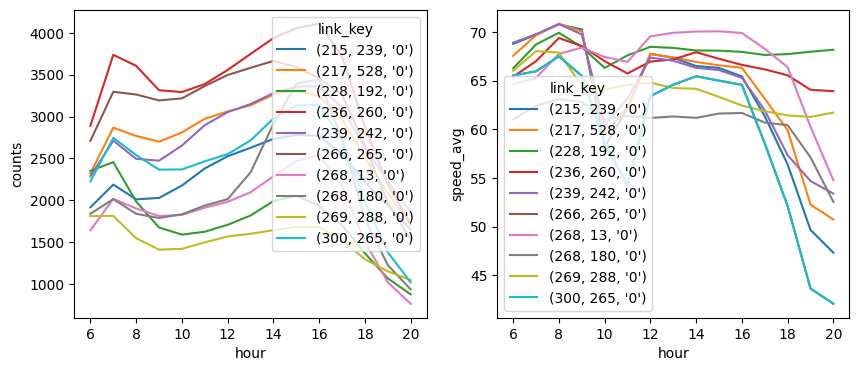

In [70]:
fig, axs = plt.subplots(1,2, figsize = (10,4))

sns.lineplot(x= 'hour', y = 'counts', hue = 'link_key',
             data =eda_df[eda_df.link_key.isin(link_keys)].groupby(['hour','link_key'])[['counts']].mean().reset_index(),
             ax = axs[0])

sns.lineplot(x= 'hour', y = 'speed_avg', hue = 'link_key',
             data =eda_df[eda_df.link_key.isin(link_keys)].groupby(['hour','link_key'])[['speed_avg']].mean().reset_index(),
             ax = axs[1])

<AxesSubplot: xlabel='hour', ylabel='speed_sd'>

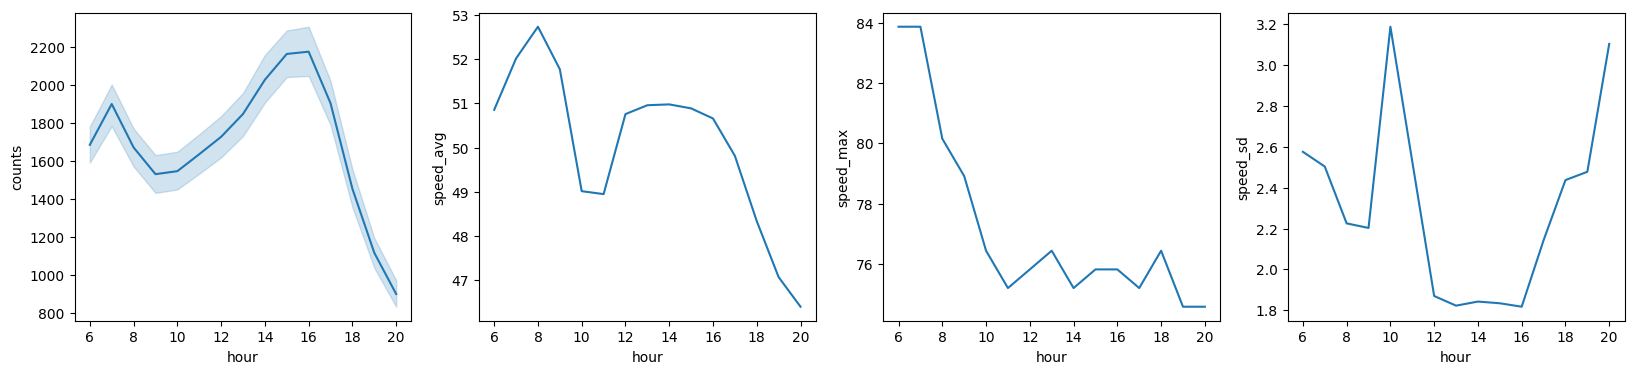

In [72]:
# Analysis for links where link counts are reported

fig, axs = plt.subplots(1,4, figsize = (20,4))

sns.lineplot(x= 'hour', y = 'counts', data =eda_df.groupby(['hour','link_key'])[['counts']].mean().reset_index(),
             ax = axs[0])

sns.lineplot(x= 'hour', y = 'speed_avg',
             data =eda_df[~eda_df.counts.isna()].groupby(['hour'])[['speed_avg']].mean().reset_index(),
             ax = axs[1])

sns.lineplot(x= 'hour', y = 'speed_max',
             data =eda_df[~eda_df.counts.isna()].groupby(['hour'])[['speed_max']].max().reset_index(),
             ax = axs[2])

sns.lineplot(x= 'hour', y = 'speed_sd',
             data =eda_df[~eda_df.counts.isna()].groupby(['hour'])[['speed_sd']].mean().reset_index(),
             ax = axs[3])

## Read models results

In [73]:
id = 221027112307
train_results_dfs = pd.read_csv(f'output/tables/{id}_train_results_Fresno.csv', index_col = [0])
test_results_dfs = pd.read_csv(f'output/tables/{id}_train_results_Fresno.csv', index_col = [0])

## Configuration

In [74]:
_XTICKS_SPACING = 50

### Model 1: Benchmark of gisuelogit and isuelogit


LUE: Benchmark of gisuelogit and isuelogit (utility only)
alpha =  0.15, beta  =  4.00


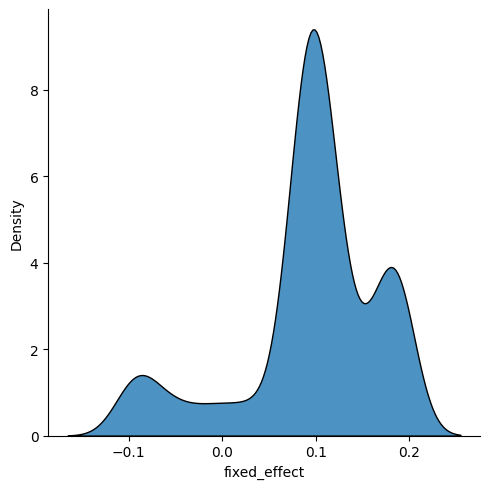

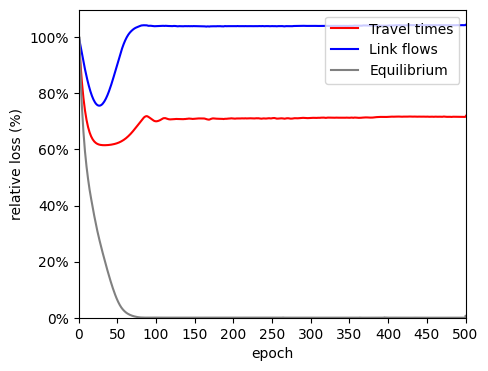

In [75]:
print('\nLUE: Benchmark of gisuelogit and isuelogit (utility only)')

sns.displot(pd.DataFrame({'fixed_effect':np.array(train_results_dfs[train_results_dfs.model == 'lue']['fixed_effect'])}),
        x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'lue'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'lue'],
                            xticks_spacing = _XTICKS_SPACING)

# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(lue.theta.numpy())))}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'lue']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'lue']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(lue.q - fresno_network.q.flatten())): 0.2f}")
# print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 2: OD + utility estimation with historic OD


ODLUE: OD + utility estimation with historic OD
alpha =  0.15, beta  =  4.00


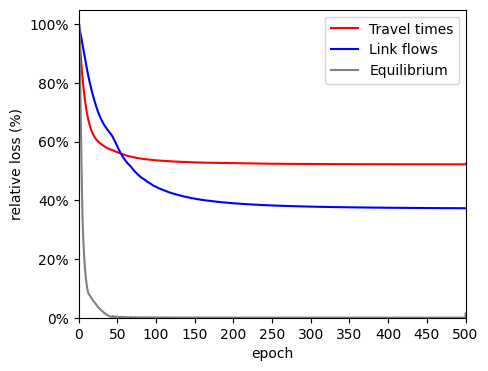

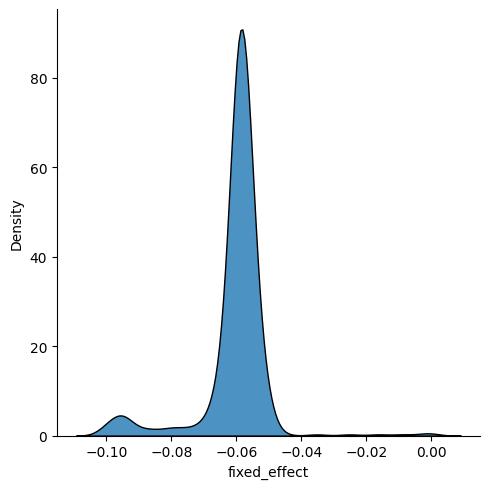

In [76]:
print('\nODLUE: OD + utility estimation with historic OD')

plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'odlue'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'odlue'],
                            show_validation= False,
                            xticks_spacing = _XTICKS_SPACING)

sns.displot(pd.DataFrame({'fixed_effect':train_results_dfs[train_results_dfs.model == 'odlue']['fixed_effect']}),
        x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(lue.theta.numpy())))}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'odlue']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'odlue']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(lue.q - fresno_network.q.flatten())): 0.2f}")
# print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 3: ODLUE + link specific performance parameters (only alphas)


ODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alpha)
alpha =  1.05, beta  =  4.00


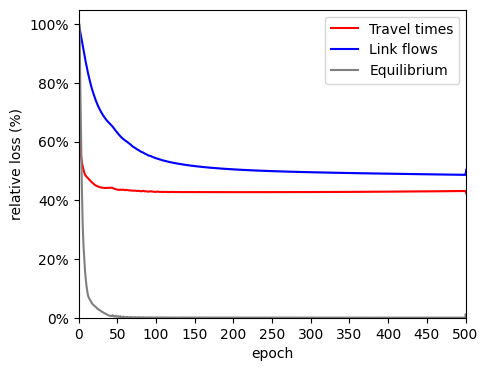

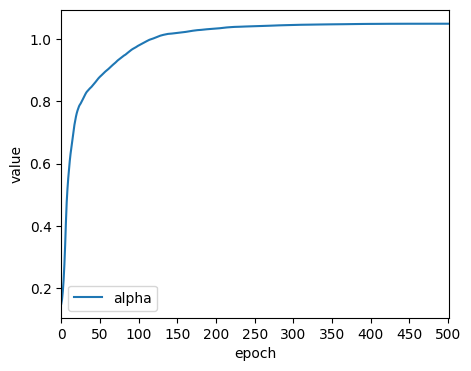

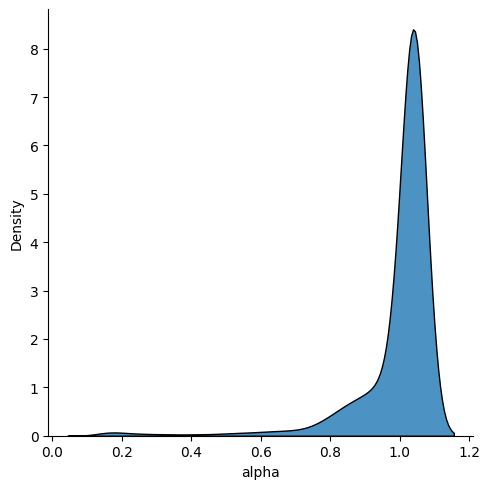

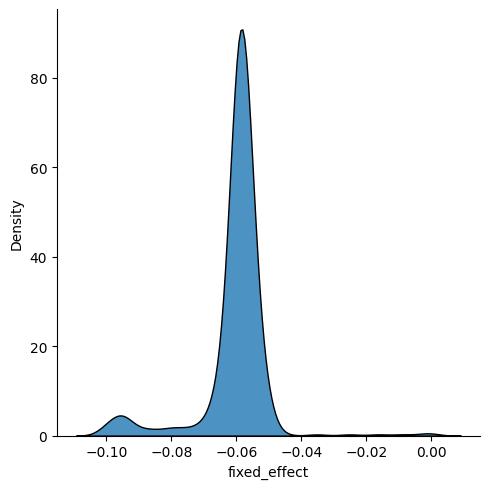

In [77]:
print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alpha)')

plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'odlulpe-1'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'odlulpe-1'],
                            show_validation= False,
                            xticks_spacing = _XTICKS_SPACING)

plot_convergence_estimates(estimates=train_results_dfs[train_results_dfs.model == 'odlulpe-1'][['epoch','alpha']],
                            xticks_spacing = _XTICKS_SPACING)

sns.displot(pd.DataFrame({'alpha':train_results_dfs[train_results_dfs.model == 'odlulpe-1']['alpha']}),
        x="alpha", multiple="stack", kind="kde", alpha = 0.8)

sns.displot(pd.DataFrame({'fixed_effect':np.array(train_results_dfs[train_results_dfs.model == 'odlue']['fixed_effect'])}),
            x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe_1.theta.numpy())))}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'odlulpe-1']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'odlulpe-1']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe_1.q - fresno_network.q.flatten())): 0.2f}")
# print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 5: ODLUE + link specific performance parameters (alphas and betas)


ODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alphas and betas)
alpha =  0.80, beta  =  2.18


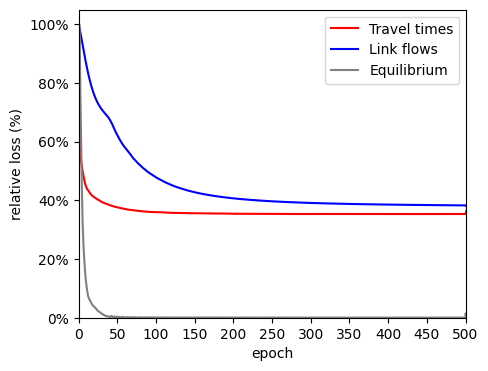

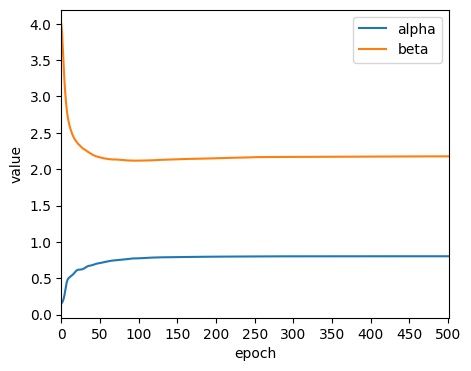

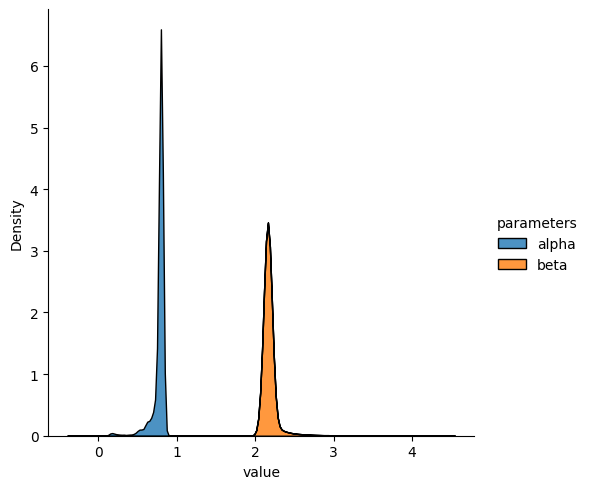

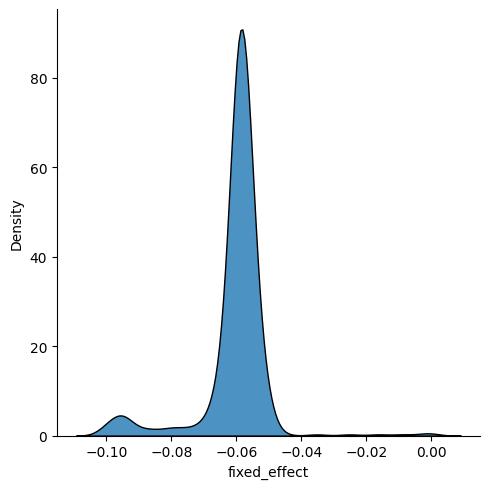

In [78]:
print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alphas and betas)')

train_results_dfs.loc[train_results_dfs.model == 'odlulpe_2','model'] = 'odlulpe-2'
test_results_dfs.loc[test_results_dfs.model == 'odlulpe_2','model'] = 'odlulpe-2'

plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'odlulpe-2'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'odlulpe-2'],
                            show_validation= False,
                            xticks_spacing = _XTICKS_SPACING)

plot_convergence_estimates(
    estimates=train_results_dfs[train_results_dfs.model == 'odlulpe-2'][['epoch','alpha','beta']],
    xticks_spacing = _XTICKS_SPACING)

sns.displot(pd.melt(pd.DataFrame({'alpha':train_results_dfs[train_results_dfs.model == 'odlulpe-2']['alpha'],
                          'beta':train_results_dfs[train_results_dfs.model == 'odlulpe-2']['beta']}), var_name = 'parameters'),
            x="value", hue="parameters", multiple="stack", kind="kde", alpha = 0.8)

sns.displot(pd.DataFrame({'fixed_effect':train_results_dfs[train_results_dfs.model == 'odlue']['fixed_effect']}),
            x="fixed_effect", multiple="stack", kind="kde", alpha = 0.8)

# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe_1.theta.numpy())))}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'odlulpe-2']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'odlulpe-2']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe_1.q - fresno_network.q.flatten())): 0.2f}")
# print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

## Summary of parameters estimates

In [22]:
_EPOCHS = {'learning': 500, 'equilibrium': 50}

In [23]:
train_results_dfs = train_results_dfs[train_results_dfs['epoch'] <= _EPOCHS['learning']]

In [24]:
train_results_dfs

,model,loss_od,loss_flow,loss_tt,loss_total,loss_eq_flow,loss_eq_tt,epoch,tt,speed_sd,median_inc,incidents,bus_stops,intersections,alpha,beta,psc_factor,fixed_effect,relative_gap
0,lue,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.150000,4.000000,0.0,0.000000,0.000010
1,lue,1.000000,0.987322,0.954752,0.354191,1.000000,NaN,1,-0.498855,-0.499992,0.0,-0.499987,-0.499943,-0.499989,0.150000,4.000000,0.0,-0.001787,24.761214
2,lue,1.000000,0.972747,0.912675,0.345597,0.892439,NaN,2,-0.803327,-0.865334,0.0,-0.873386,-0.844833,-0.838423,0.150000,4.000000,0.0,-0.010335,0.670986
3,lue,1.000000,0.957802,0.874735,0.337689,0.815655,NaN,3,-1.025090,-1.158949,0.0,-1.173994,-1.115767,-1.100729,0.150000,4.000000,0.0,-0.018565,0.319642
4,lue,1.000000,0.942886,0.840815,0.330235,0.755353,NaN,4,-1.198690,-1.403418,0.0,-1.432467,-1.335838,-1.312928,0.150000,4.000000,0.0,-0.026819,0.201552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,odlulpe-2,1637.959652,0.382874,0.353676,0.002536,0.000297,NaN,497,-3.048074,-3.707728,0.0,-3.708657,-2.793998,-3.261020,0.802789,2.176415,0.0,-0.068977,0.006397
498,odlulpe-2,1647.713842,0.383095,0.353571,0.002509,0.000261,NaN,498,-3.044932,-3.707783,0.0,-3.709410,-2.793623,-3.258312,0.802780,2.176426,0.0,-0.068872,0.006682
499,odlulpe-2,1638.682139,0.382855,0.353667,0.002486,0.000295,NaN,499,-3.048906,-3.708705,0.0,-3.708921,-2.794773,-3.261642,0.802794,2.176462,0.0,-0.068962,0.006353
500,odlulpe-2,1648.328849,0.383075,0.353562,0.002460,0.000261,NaN,500,-3.045775,-3.708654,0.0,-3.709954,-2.793773,-3.258941,0.802785,2.176473,0.0,-0.068800,0.006675


In [25]:
models = train_results_dfs.model.unique()

In [ ]:
results = pd.DataFrame({'parameter': [], 'model': []})

for model in models.keys():
    results = results.append(pd.DataFrame(
        {'parameter': ['tt'] + features_Z +
                      ['fixed_effect_mean','fixed_effect_std',
                       'alpha_mean', 'alpha_std',
                       'beta_mean', 'beta_std',
                       'od_mean', 'od_std',],
         'values': list(model.theta.numpy()) +
                   [np.mean(model.fixed_effect),np.std(model.fixed_effect),
                    np.mean(model.alpha),np.std(model.alpha),
                    np.mean(model.beta),np.std(model.beta),
                    np.mean(model.q),np.std(model.q)]}).\
                             assign(model = model.key)
                             )